# Part 2 · Modeling Alpha Signals
Use the feature parquet produced earlier to train a cross-sectional gradient boosting model and evaluate forward-return prediction skill.

In [1]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src import config, modeling

sns.set_theme(style='whitegrid')
config.ensure_directories()

{'artifacts': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts'),
 'feature_store': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/features'),
 'models': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/models'),
 'plots': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/plots'),
 'reports': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/reports')}

## 1. Load feature store
We reuse the parquet artifact to guarantee the same training sample across runs.

In [2]:
feature_path = config.FEATURE_STORE
feature_matrix = pd.read_parquet(feature_path)
feature_matrix.head()

Open       High        Low      Close       Volume  \
Date       Asset                                                                
2017-01-11 Asset_001  34.887014  35.236649  34.845881  35.183763  132870787.0   
           Asset_002  78.092359  78.865673  77.867848  78.815781   15817576.0   
           Asset_003  41.093443  41.254245  40.908140  41.241992   28034792.0   
           Asset_004  45.403470  45.737563  45.166057  45.710105   43426705.0   
           Asset_005   3.418645   3.425095   3.358980   3.391553  402647906.0   

                        ret_1d    mom_1d    ret_3d    mom_3d    ret_5d  ...  \
Date       Asset                                                        ...   
2017-01-11 Asset_001  0.005373  0.005373  0.015605  0.015605  0.032150  ...   
           Asset_002  0.009102  0.009102  0.005570  0.005570  0.014286  ...   
           Asset_003  0.003877  0.003877  0.002183  0.002183  0.026700  ...   
           Asset_004  0.003920  0.003920  0.003807  0.003807  0.055258  ...   
           Asset_005 -0.012304 -0.012304  0.019981  0.019981  0.007376  ...   

                      close_location  intraday_range  momentum_21d  \
Date       Asset                                                     
2017-01-11 Asset_001        0.364662        0.011214      0.039587   
           Asset_002        0.449999        0.012814      0.003334   
           Asset_003        0.464599        0.008461      0.014835   
           Asset_004        0.451955        0.012653      0.031872   
           Asset_005       -0.007318        0.019683      0.153450   

                      momentum_63d  momentum_126d  momentum_252d  cs_ret_1d_z  \
Date       Asset                                                                
2017-01-11 Asset_001      0.023249       0.211744       0.231037     0.311149   
           Asset_002      0.107922       0.205752       0.253600     0.665586   
           Asset_003      0.037738       0.096274       0.135231     0.168907   
           Asset_004     -0.029090       0.079830       0.339446     0.173046   
           Asset_005      0.595961       0.971442       2.735782    -1.368930   

                      cs_vol_21d_z  fwd_return_1d  fwd_return_5d  
Date       Asset                                                  
2017-01-11 Asset_001     -1.037806      -0.004175       0.002004  
           Asset_002     -0.563787      -0.009179      -0.010919  
           Asset_003     -0.531347      -0.001918      -0.002277  
           Asset_004      0.357498       0.018297       0.010588  
           Asset_005      4.854811      -0.016356      -0.021016  

[5 rows x 39 columns]

## 2. Model training
HistGradientBoostingRegressor with light regularization was chosen to model cross-sectional non-linearities without overfitting the relatively small feature set.

In [3]:
model_result = modeling.train_model(feature_matrix)
model_result.train_metrics, model_result.val_metrics

({'rmse': 0.035252873209577956, 'ic': 0.3662218848572379},
 {'rmse': 0.03992009689113553, 'ic': 0.031686313080301565})

## 3. Feature importance
Show which features contribute most to the cross-sectional predictions.

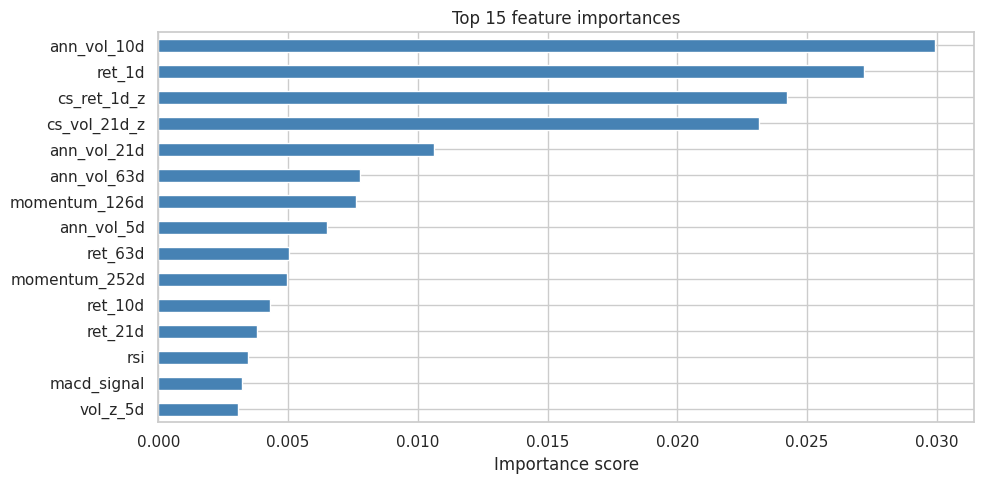

In [4]:
importance = model_result.feature_importances.sort_values(ascending=False).head(15)
fig, ax = plt.subplots(figsize=(10, 5))
importance[::-1].plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Top 15 feature importances')
ax.set_xlabel('Importance score')
plt.tight_layout()

## 4. Persist alpha scores
Predictions are stored for downstream portfolio construction and stat-arb overlays.

In [5]:
alpha_df = pd.DataFrame({'alpha_signal': model_result.predictions})
alpha_df.to_parquet(config.ALPHA_STORE)

# Smooth the alpha signal to reduce noise
alpha_smoothed = modeling.smooth_alpha_signal(alpha_df)
alpha_smoothed.to_parquet(config.ALPHA_STORE_SMOOTHED)

alpha_smoothed.head()

alpha_signal  alpha_signal_smoothed
Date       Asset                                         
2017-01-11 Asset_001      0.003084               0.003084
           Asset_002      0.003278               0.003278
           Asset_003      0.004533               0.004533
           Asset_004      0.003588               0.003588
           Asset_005     -0.008495              -0.008495

# Part 2 · Modeling & Signal Design
Transform the engineered feature store into cross-sectional alpha estimates via gradient boosting, then define how the scores will drive portfolio weights.

In [6]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src import config, modeling

config.ensure_directories()

{'artifacts': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts'),
 'feature_store': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/features'),
 'models': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/models'),
 'plots': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/plots'),
 'reports': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/reports')}